# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [2]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


## ⚙️ Import Libraries

In [7]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision

import pandas as pd
import random
from sklearn.model_selection import train_test_split
seed = 42
# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

seed = 42

np.random.seed(seed)
tf.random.set_seed(seed);

2.17.1


## ⏳ Load the Data

In [8]:
data = np.load('training_set.npz')
X = data['images'] # Array of 13759 images (96x96x3 each)
y = data['labels'] # Array of 13759 labels (numbers from 0 to 7)

X = X[:11959]
y = y[:11959]

print(X.shape)
print(y.shape)

# Step 1: Identifica e rimuovi immagini con etichette differenti
unique_images = {}
filtered_indices = []

for i in range(len(X)):
    img = X[i].tobytes()  # Converti l'immagine in un formato "hashable" (byte string)
    if img not in unique_images:
        unique_images[img] = y[i]
        filtered_indices.append(i)
    elif unique_images[img] != y[i]:
        # Se c'è una differenza tra le etichette per la stessa immagine, escludi questa riga
        continue

# Filtra il dataset per includere solo le righe valide
X_filtered = X[filtered_indices]
y_filtered = y[filtered_indices]

# Step 2: Rimuovi coppie duplicate (stessa immagine e stessa etichetta)
unique_pairs = set()
final_indices = []

for i in range(len(X_filtered)):
    img_label_pair = (X_filtered[i].tobytes(), y_filtered[i].item)  # Usa l'immagine come chiave e l'etichetta come valore
    if img_label_pair not in unique_pairs:
        unique_pairs.add(img_label_pair)
        final_indices.append(i)

# Filtra il dataset per rimuovere i duplicati
X_final = X_filtered[final_indices]
y_final = y_filtered[final_indices]

# Ora X_final e y_final sono i tuoi dati puliti
print(f"Dimensioni finali del dataset: X = {X_final.shape}, y = {y_final.shape}")

(11959, 96, 96, 3)
(11959, 1)
Dimensioni finali del dataset: X = (11951, 96, 96, 3), y = (11951, 1)


Generate the Splits

In [9]:
TEST_SIZE = round(X.shape[0] / 10) # 10%
VAL_SIZE = round(X.shape[0] / 10) # 10%

# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=seed,
    stratify=y
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=VAL_SIZE,
    random_state=seed,
    stratify=y_train_val
)

class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

# Convert class labels to categorical format for training, validation, and test sets
y_train = tfk.utils.to_categorical(y_train, num_classes=len(class_names))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(class_names))
y_test = tfk.utils.to_categorical(y_test, num_classes=len(class_names))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Print the shapes of the resulting sets
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)
print('Test set shape:\t\t', X_test.shape, y_test.shape)


X_train shape: (9567, 96, 96, 3), y_train shape: (9567, 8)
X_val shape: (1196, 96, 96, 3), y_val shape: (1196, 8)
X_test shape: (1196, 96, 96, 3), y_test shape: (1196, 8)
Training set shape:	 (9567, 96, 96, 3) (9567, 8)
Validation set shape:	 (1196, 96, 96, 3) (1196, 8)
Test set shape:		 (1196, 96, 96, 3) (1196, 8)


Initialise MobileNetV3Small model with pretrained weights, for transfer learning

In [ ]:
# Initialise MobileNetV3Small model with pretrained weights, for transfer learning
mobilenet = tfk.applications.MobileNetV3Small(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    include_preprocessing=True
)

# Display a summary of the model architecture
mobilenet.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(mobilenet, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_9 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 48, 48, 16)     │            432 │ rescaling_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 48, 48, 16)     │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_162            │ (None, 48, 48, 16)     │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 49, 49, 16)     │              0 │ activation_162[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 24, 24, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 24, 24, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_126 (ReLU)          │ (None, 24, 24, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu_126[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_81 (Add)              │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_127 (ReLU)     

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [ ]:
# Freeze all layers in MobileNetV3Small to use it solely as a feature extractor
mobilenet.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Apply data augmentation for training robustness
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomTranslation(0.2, 0.2)
], name='preprocessing')

x = augmentation(inputs)

# Pass augmented inputs through the MobileNetV3Small feature extractor
x = mobilenet(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_9 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_9            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 576)                 │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_18 (InputLayer)     │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_9 (Rescaling)         │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv (Conv2D)                   │ (None, 48, 48, 16)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation_162 (Activation)     │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_pad     │ (None, 49, 49, 16)          │               0 │
│ (ZeroPadding2D)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 24, 24, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_bn      │ (None, 24, 24, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu_126 (ReLU)                │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 16)            │               0 │
│ expanded_conv_squeeze_excite_avg_po… │                             │                 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 8)             │             136 │
│ expanded_conv_squeeze_excite_conv    │                             │                 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 8)             │               0 │
│ expanded_conv_squeeze_excite_relu    │                             │              

 Total params: 943,736 (3.60 MB)

 Trainable params: 4,616 (18.03 KB)

 Non-trainable params: 939,120 (3.58 MB)

## 🛠️ Train and Save the Model

In [ ]:
# Add your implementation here
model = tl_model

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 1000,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model.save('weights.keras')
del model

Epoch 1/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 228ms/step - accuracy: 0.4021 - loss: 1.6864 - val_accuracy: 0.8119 - val_loss: 0.6363
Epoch 2/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.7619 - loss: 0.7256 - val_accuracy: 0.8595 - val_loss: 0.4932
Epoch 3/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.8008 - loss: 0.5863 - val_accuracy: 0.8645 - val_loss: 0.4465
Epoch 4/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.8229 - loss: 0.5264 - val_accuracy: 0.8712 - val_loss: 0.4154
Epoch 5/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 0.8325 - loss: 0.4881 - val_accuracy: 0.8746 - val_loss: 0.3931
Epoch 6/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.8458 - loss: 0.4632 - val_accuracy: 0.8888 - val_loss: 0.3696
Epoch 7/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.8455 - loss: 0.4465 - val_accuracy: 0.8788 - val_loss: 0.3630
Epoch 8/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('weights.keras')

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_8 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_8            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 576)                 │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_16 (InputLayer)     │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_8 (Rescaling)         │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv (Conv2D)                   │ (None, 48, 48, 16)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation_144 (Activation)     │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_pad     │ (None, 49, 49, 16)          │               0 │
│ (ZeroPadding2D)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 24, 24, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_bn      │ (None, 24, 24, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu_112 (ReLU)                │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 16)            │               0 │
│ expanded_conv_squeeze_excite_avg_po… │                             │                 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 8)             │             136 │
│ expanded_conv_squeeze_excite_conv    │                             │                 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 8)             │               0 │
│ expanded_conv_squeeze_excite_relu    │                             │              

 Total params: 952,970 (3.64 MB)

 Trainable params: 4,616 (18.03 KB)

 Non-trainable params: 939,120 (3.58 MB)

 Optimizer params: 9,234 (36.07 KB)

In [ ]:
# Set the MobileNetV3Small model layers as trainable
ft_model.get_layer('MobileNetV3Small').trainable = True

# Set all MobileNetV3Small layers as non-trainable
for layer in ft_model.get_layer('MobileNetV3Small').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('MobileNetV3Small').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

2 conv Conv2D True
6 expanded_conv_depthwise DepthwiseConv2D True
10 expanded_conv_squeeze_excite_conv Conv2D True
12 expanded_conv_squeeze_excite_conv_1 Conv2D True
15 expanded_conv_project Conv2D True
17 expanded_conv_1_expand Conv2D True
21 expanded_conv_1_depthwise DepthwiseConv2D True
24 expanded_conv_1_project Conv2D True
26 expanded_conv_2_expand Conv2D True
29 expanded_conv_2_depthwise DepthwiseConv2D True
32 expanded_conv_2_project Conv2D True
35 expanded_conv_3_expand Conv2D True
39 expanded_conv_3_depthwise DepthwiseConv2D True
43 expanded_conv_3_squeeze_excite_conv Conv2D True
45 expanded_conv_3_squeeze_excite_conv_1 Conv2D True
48 expanded_conv_3_project Conv2D True
50 expanded_conv_4_expand Conv2D True
53 expanded_conv_4_depthwise DepthwiseConv2D True
57 expanded_conv_4_squeeze_excite_conv Conv2D True
59 expanded_conv_4_squeeze_excite_conv_1 Conv2D True
62 expanded_conv_4_project Conv2D True
65 expanded_conv_5_expand Conv2D True
68 expanded_conv_5_depthwise DepthwiseConv2

0 input_layer_16 False
1 rescaling_8 False
2 conv False
3 conv_bn False
4 activation_144 False
5 expanded_conv_depthwise_pad False
6 expanded_conv_depthwise False
7 expanded_conv_depthwise_bn False
8 re_lu_112 False
9 expanded_conv_squeeze_excite_avg_pool False
10 expanded_conv_squeeze_excite_conv False
11 expanded_conv_squeeze_excite_relu False
12 expanded_conv_squeeze_excite_conv_1 False
13 re_lu_113 False
14 expanded_conv_squeeze_excite_mul False
15 expanded_conv_project False
16 expanded_conv_project_bn False
17 expanded_conv_1_expand False
18 expanded_conv_1_expand_bn False
19 re_lu_114 False
20 expanded_conv_1_depthwise_pad False
21 expanded_conv_1_depthwise False
22 expanded_conv_1_depthwise_bn False
23 re_lu_115 False
24 expanded_conv_1_project False
25 expanded_conv_1_project_bn False
26 expanded_conv_2_expand False
27 expanded_conv_2_expand_bn False
28 re_lu_116 False
29 expanded_conv_2_depthwise False
30 expanded_conv_2_depthwise_bn False
31 re_lu_117 False
32 expanded_conv_

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_8 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_8            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 576)                 │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_16 (InputLayer)     │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_8 (Rescaling)         │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv (Conv2D)                   │ (None, 48, 48, 16)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv_bn (BatchNormalization)    │ (None, 48, 48, 16)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ activation_144 (Activation)     │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_pad     │ (None, 49, 49, 16)          │               0 │
│ (ZeroPadding2D)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 24, 24, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_bn      │ (None, 24, 24, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ re_lu_112 (ReLU)                │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 16)            │               0 │
│ expanded_conv_squeeze_excite_avg_po… │                             │                 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 8)             │             136 │
│ expanded_conv_squeeze_excite_conv    │                             │                 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 1, 1, 8)             │               0 │
│ expanded_conv_squeeze_excite_relu    │                             │              

 Total params: 952,970 (3.64 MB)

 Trainable params: 643,112 (2.45 MB)

 Non-trainable params: 300,624 (1.15 MB)

 Optimizer params: 9,234 (36.07 KB)

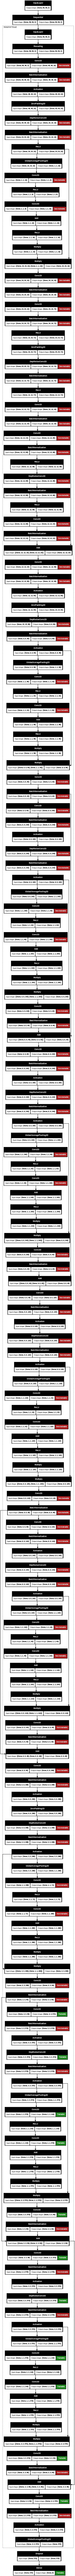

In [ ]:
# Set the number of layers to freeze
N = 124

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('MobileNetV3Small').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('MobileNetV3Small').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 1000,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'blood_cells'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 255ms/step - accuracy: 0.8412 - loss: 0.4577 - val_accuracy: 0.8946 - val_loss: 0.3147
Epoch 2/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 242ms/step - accuracy: 0.8866 - loss: 0.3305 - val_accuracy: 0.9122 - val_loss: 0.2592
Epoch 3/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.9012 - loss: 0.2775 - val_accuracy: 0.9139 - val_loss: 0.2317
Epoch 4/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - accuracy: 0.9152 - loss: 0.2447 - val_accuracy: 0.9156 - val_loss: 0.2151
Epoch 5/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - accuracy: 0.9241 - loss: 0.2137 - val_accuracy: 0.9214 - val_loss: 0.2040
Epoch 6/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step - accuracy: 0.9308 - loss: 0.1944 - val_accuracy: 0.9222 - val_loss: 0.2006
Epoch 7/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 241ms/step - accuracy: 0.9367 - loss: 0.1762 - val_accuracy: 0.9331 - val_loss: 0.1803
Epoch 8/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 245ms/step - accuracy: 

KeyboardInterrupt: 

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [4]:
#%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [10]:
# Predict labels for the entire test set
model = Model()

predictions = model.predict(X_test)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)
print(true_classes)
# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, predictions)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, predictions, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, predictions, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, predictions, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predictions)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(class_names), yticklabels=list(class_names), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step
Predictions Shape: (1196,)
[6 6 0 ... 7 7 6]
Accuracy score over the test set: 0.9089
Precision score over the test set: 0.9119
Recall score over the test set: 0.9089
F1 score over the test set: 0.9093


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)